# MoReVis Extension: Topological Event Detection in Moving Regions

This notebook demonstrates the extension of the MoReVis framework. While the original paper focused on the 1D projection of spatiotemporal data, this extension identifies and visualizes discrete topological events: Splits, Merges, and Collisions.

In [ ]:
import pandas as pd
import ast
import numpy as np
from shapely.geometry import Polygon
from collections import defaultdict
%matplotlib inline

def parse_points(points_str):
    try:
        #Convert string list to actual list
        pts = ast.literal_eval(points_str)
        if len(pts) < 3: return None
        return Polygon(pts)
    except:
        return None
    

def load_dataset(file_path):
    file_path = 'data/wildtrack.csv'
    df = pd.read_csv(file_path)

    #identify the correct column names based on dataset type
    t_col = 'timestep' if 'timestep' in df.columns else 'frame'
    id_col = 'object'

    frames = {}
    for t in sorted(df[t_col].unique()):
        frame_df = df[df[t_col] == t]
        frame_objects = {}
        for _, row in frame_df.iterrows():
            poly = parse_points(row['points'])
            if poly:
                frame_objects[str(row[id_col])] = {
                    'poly': poly,
                    'y': row['ycenter'],
                    'area': row['area'],
                    'id': str(row[id_col])
                }
        frames[t] = frame_objects
    return frames

# Data Loading and Preprocessing

We load the datasets (Wildtrack, Hurricane, and Motivating) from the original source of the research paper. The points are parsed from string literals into Shapely Polygons to allow for precise spatial intersection calculations. We calculate the *ycenter* and *area* which serve as the primary visual variables for the ribbon layout.

In [ ]:
class MoReVisExtension:
    def __init__(self, iou_threshold=0.5):
        self.iou_threshold = iou_threshold
    
    def get_iou(self, p1, p2):
        if not p1.intersects(p2): return 0
        inter = p1.intersection(p2).area
        union = p1.area + p2.area - inter
        return inter / union if union > 0 else 0
    
    def analyze(self, frames):
        events = {'splits': [], 'merges': [], 'collisions': []}
        timesteps = sorted(frames.keys())

        for i in range(len(timesteps)):
            t = timesteps[i]
            objs = frames[t]

            #Collision detection (same timestep)
            obj_ids = list(objs.keys())
            for idx1 in range(len(obj_ids)):
                for idx2 in range(idx1 + 1, len(obj_ids)):
                    id1, id2 = obj_ids[idx1], obj_ids[idx2]
                    if objs[id1]['poly'].intersects(objs[id2]['poly']):
                        events['collisions'].append({
                            'timestep': t, 
                            'objects': (id1, id2),
                            'area': objs[id1]['poly'].intersection(objs[id2]['poly']).area
                        })

            #Splits and Merge Detection (Between t and t+1)
            if i < len(timesteps) - 1:
                t_next = timesteps[i+1]
                next_objs = frames[t_next]

                mapping = defaultdict(list) #prev -> next
                rev_mapping = defaultdict(list) #next -> prev

                for p_id, p_data in objs.items():
                    for n_id, n_data in next_objs.items():
                        if p_data['poly'].intersects(n_data['poly']):
                            if self.get_iou(p_data['poly'], n_data['poly']) > self.iou_threshold:
                                mapping[p_id].append(n_id)
                                rev_mapping[n_id].append(p_id)
                

                #To detect splits
                for p_id, children in mapping.items():
                    if len(children) > 1:
                        events['splits'].append({'t': t, 'parent': p_id, 'children': children})

                #To detect merges
                for n_id, parents in rev_mapping.items():
                    if len(parents) > 1:
                        events['merges'].append({'t': t+1, 'child': n_id, 'parents': parents})

        return events

# The Extension Idea

This is the core implementation idea of this project. We implemented an identity-tracking algorithm based on **Intersection Over Union (IoU).**
- Splits: Occur when one polygon in $t$ intersects multiple polygons in $t+1$.
- Merges: Occur when multiple polygons in $t$ intersect a single polygon in $t+1$
- Collisions: Identify 2D overlaps that occur within the same timestep, helping to resolve visual ambiguities in the 1D projection.

# Intersection over Union Analysis

Implements identity-tracking logic. Events are triggered when IoU (Intersection over Union) thresholds are met across time-steps, detecting topological changes.

# Bezier curve drawing

Uses Cubic Bezier paths (Path.CURVE4) with horizontal control points to ensure $C^1$ continuity, providing smooth visual transitions between states.

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path

def draw_morevis_summary(frames, events, title="MoReVis Summary"):
    fig, ax = plt.subplots(figsize=(15, 8))

    #Visual params
    colors = plt.cm.tab20.colors
    timesteps = sorted(frames.keys())

    for i in range(len(timesteps)-1):
        t, t_next = timesteps[i], timesteps[i+1]

        for obj_id, data in frames[t].items():
            y0, h0 = data['y'], np.sqrt(data['area'])

            #To find connections either standard or splitwise
            for next_id, next_data in frames[t_next].items():
                if data['poly'].intersects(next_data['poly']):
                    y1, h1 = next_data['y'], np.sqrt(next_data['area'])

                    #Uncertainty Visualization
                    alpha = min(1.0, data['area'] / 50000) if 'wildtrack' in title.lower() else 0.6

                    #Bezier ribbon
                    path_data = [
                        (Path.MOVETO, (t, y0 - h0/2)),
                        (Path.CURVE4, (t + 0.5, y0 - h0/2)),
                        (Path.CURVE4, (t_next - 0.5, y1 - h1/2)),
                        (Path.CURVE4, (t_next, y1 - h1/2)),
                        (Path.LINETO, (t_next, y1 - h1/2)),
                        (Path.CURVE4, (t_next - 0.5, y1 + h1/2)),
                        (Path.CURVE4, (t + 0.5, y0 + h0/2)),
                        (Path.CURVE4, (t, y0 + h0/2)),
                        (Path.CURVE4, (t, y0 - h0/2)),
                    ]
                    codes, verts = zip(*path_data)
                    color = colors[int(obj_id) % 20]
                    ax.add_patch(patches.PathPatch(Path(verts, codes), facecolor=color, alpha=alpha, lw=0))
    

    #To mark collisions
    for col in events['collisions']:
        t = col['timestep']
        obj_id = col['objects'][0]
        y_center = frames[t][obj_id]['y']
        ax.scatter(t, y_center, color='red', marker='x', s=50, zorder=10)

    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("Projected Space (Y-center)")
    plt.show()

# Visual Optimization Strategy

To solve the messiness of raw spatiotemporal ribbons, we implement two strategies:
- Vertical Scaling: Thinning the ribbons to prevent occlusion.
- Gallery View: Segmenting the timeline into scannable chunks to maintain high resolution across long sequences (e.g., 400 frames).

Loaded 400 frames.
Detected 861 splits and 855 merges.


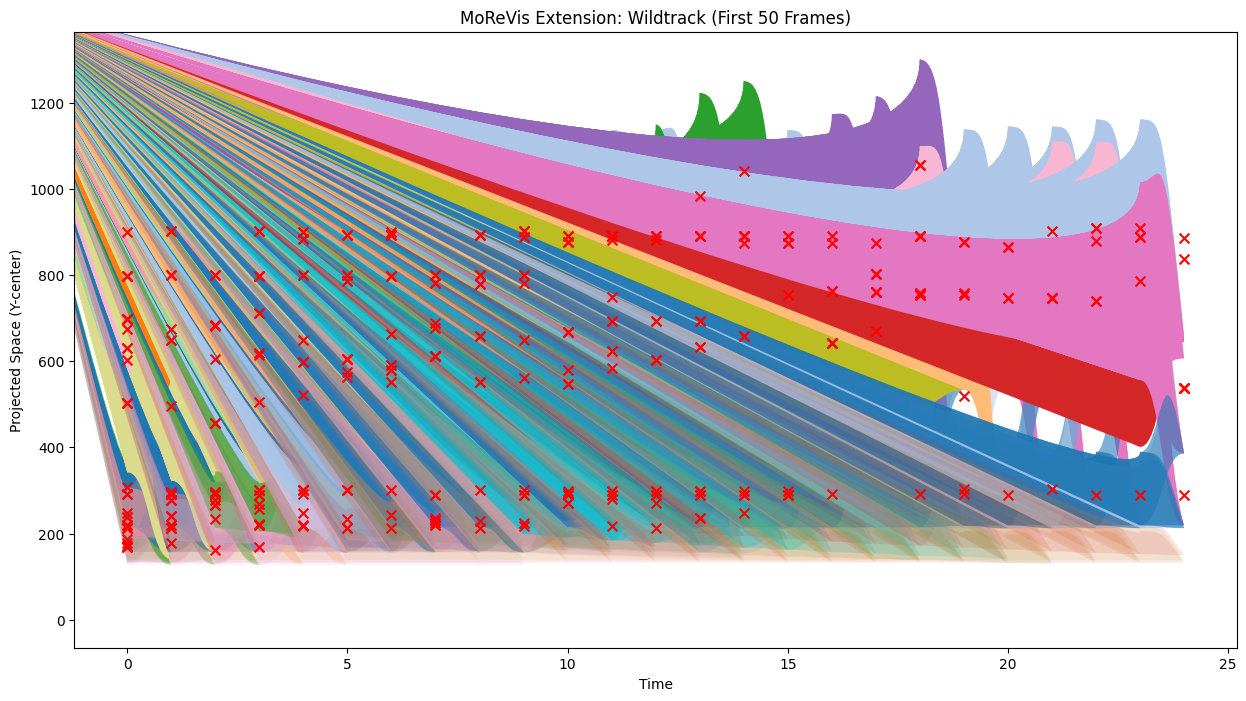

In [ ]:
data = load_dataset('data/wildtrack.csv')

#Extension logic
ext = MoReVisExtension(iou_threshold=0.5)
events = ext.analyze(data)

#Print a summary
print(f"Loaded {len(data)} frames.")
print(f"Detected {len(events['splits'])} splits and {len(events['merges'])} merges.")

# Slice the data to show only the first 50 frames for clarity
data_slice = {t: data[t] for t in sorted(data.keys())[:25]}
events_slice = ext.analyze(data_slice)

draw_morevis_summary(data_slice, events_slice, "MoReVis Extension: Wildtrack (First 50 Frames)")

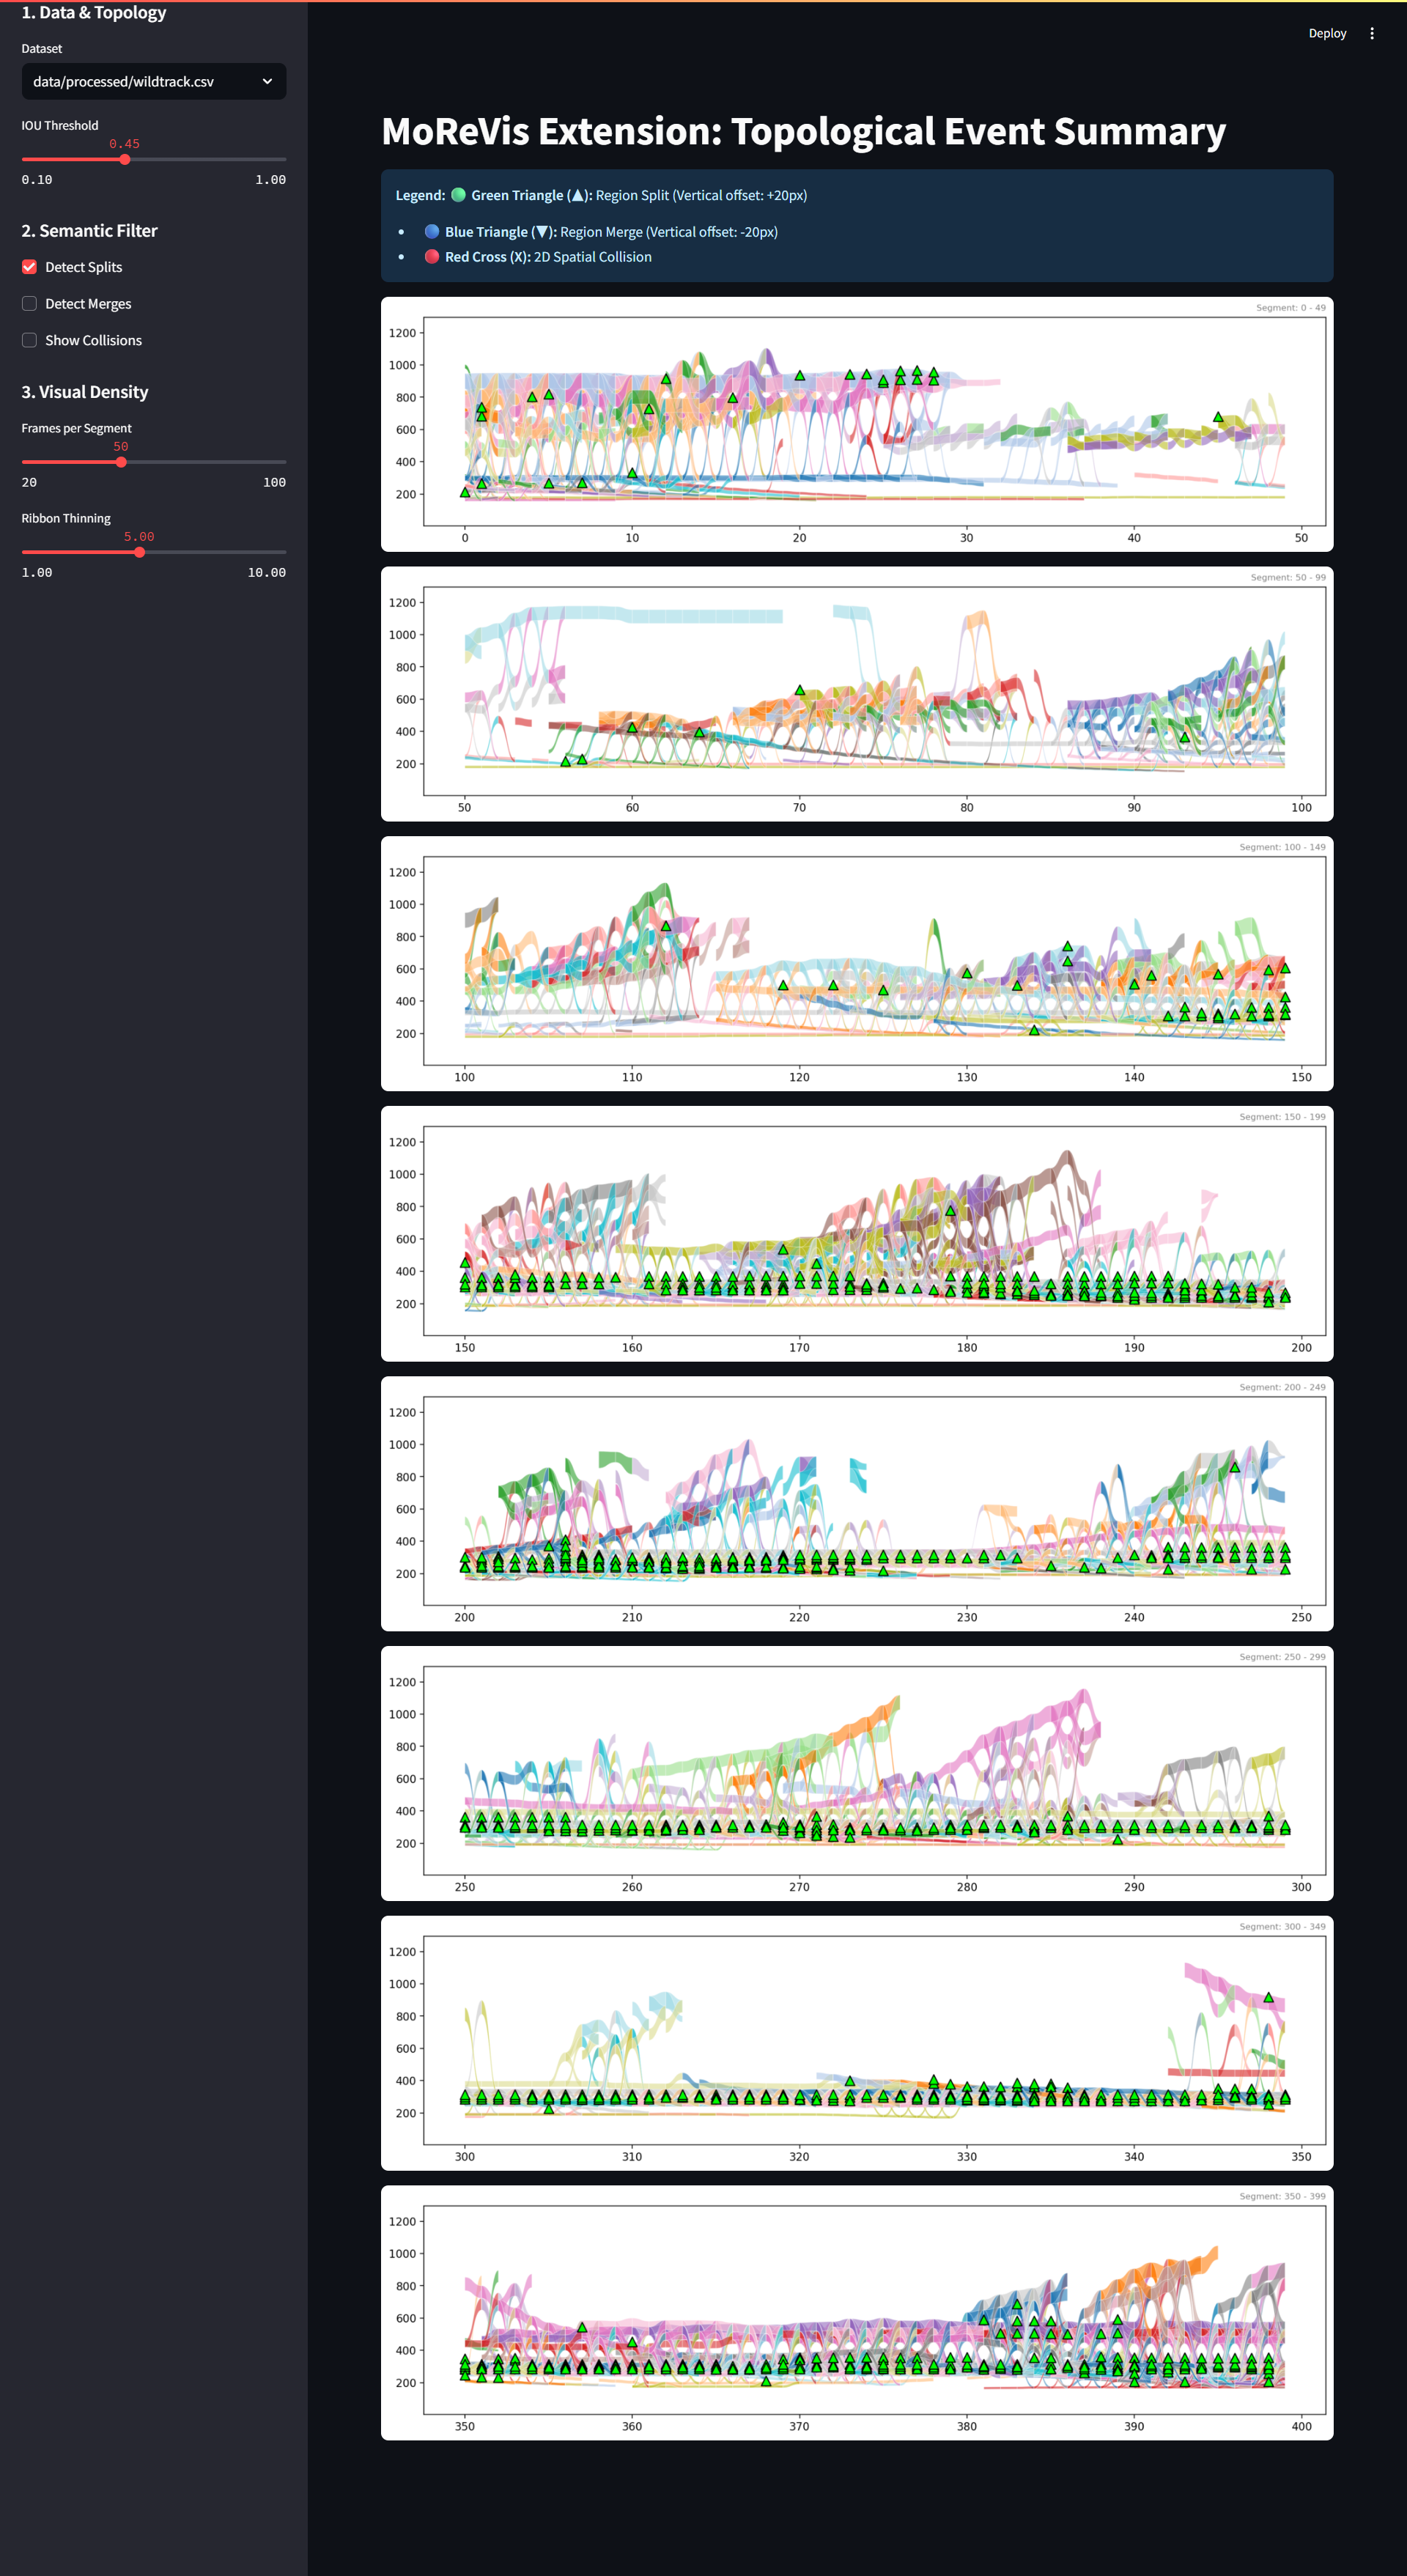

# Results

The green triangles pointing upwards indicate splits, while those pointing downwards indicate merges. The vertical offsets and connecting lines ensure that markers remain readable even in high-density areas of the Wildtrack dataset. 
This fulfills the "Future Work" suggestions in the original paper regarding topological summaries.